# Titanic Machine Learning from disaster Kaggle competition

---

## Setup

In [37]:
library(data.table)
library(ggplot2)
library(RColorBrewer)

rm(list = ls())

In [38]:
TrainSet <- fread("train.csv")

---

## EDA

### Structure

First of all, we want to inspect the names of the variables as well as the number of unique values:

In [39]:
TrainSet[, lapply(.SD, uniqueN)]
nrow(TrainSet)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
891,2,3,891,2,89,7,7,681,248,148,4


[1] 891

Considering that the total number of observations is 891, **PassengerId**, **Name** and **Ticket** variables are useless for prediction. Thus, we can just drop them:

In [40]:
TrainSet[, PassengerId:= NULL
         ][, Name:= NULL
           ][, Ticket := NULL]

Secondly, we examine missing values:

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE


Survived,V1
<fct>,<int>
0,125
1,52


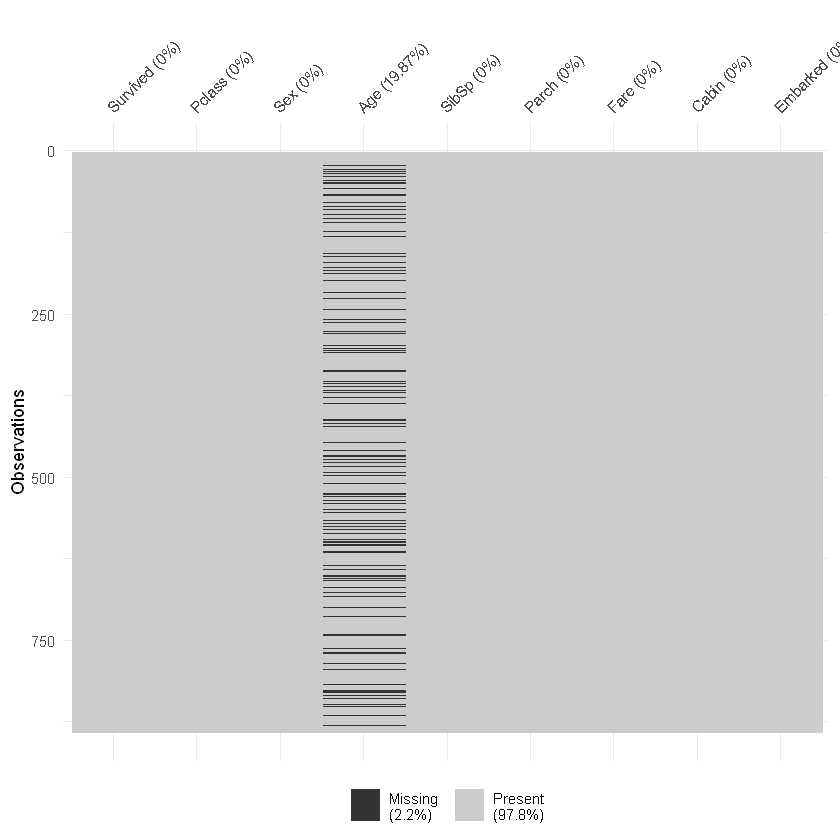

In [61]:
TrainSet[, lapply(.SD, anyNA)]
TrainSet[, sum(is.na(Age)), by = Survived]
naniar::vis_miss(TrainSet)

As we see **Age** is the only variable that contains missing values. This will be taken into account at Feature engeneering part.

Next, we explore the classes of variables:

In [42]:
TrainSet[, lapply(.SD, class)]

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
integer,integer,character,numeric,integer,integer,numeric,character,character


And convert all characters to factor to correctly visualize and build models on them:

In [43]:
ColumnsToFactor <- c("Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked")
TrainSet[, (ColumnsToFactor) := lapply(.SD, as.factor), .SDcols = ColumnsToFactor]

---

### Frequency distributions

Before looking at frequency distrivutions, we initialize functions used for plots and summary statistics table creation:

In [47]:
CreateFrequencyDistributionPlot <- function(TrainSet, AxisX, TypeAxisX = "categorical") {
  if (TypeAxisX == "categorical") {
    ggplot(TrainSet, aes_string(AxisX, fill = AxisX)) +
      geom_bar() +
      theme_minimal() +
      scale_color_brewer(palette = "Accent") +
      labs(y = "Number of observations", title = paste("Bar plot of ", AxisX, " variable"))    
  } else {
    ggplot(TrainSet, aes_string(AxisX)) +
      geom_histogram(color = "red", fill = "deepskyblue3") +
      theme_minimal() +
      labs(y = "Number of observations", title = paste("Histogram of ", AxisX, " variable"))
  }
}

CreateSummaryStatisticsTable <- function(VariableContinuous) {
  data.table(Min = min(VariableContinuous, na.rm = TRUE),
             Q25 = quantile(VariableContinuous, 0.25, na.rm = TRUE),
             Median = median(VariableContinuous, na.rm = TRUE),
             Q75 = quantile(VariableContinuous, 0.75, na.rm = TRUE),
             Max = max(VariableContinuous, na.rm = TRUE),
             Mean = mean(VariableContinuous, na.rm = TRUE),
             `Standard Deviation` = sd(VariableContinuous, na.rm = TRUE))
}

Then we explore all the categorical variables at first:

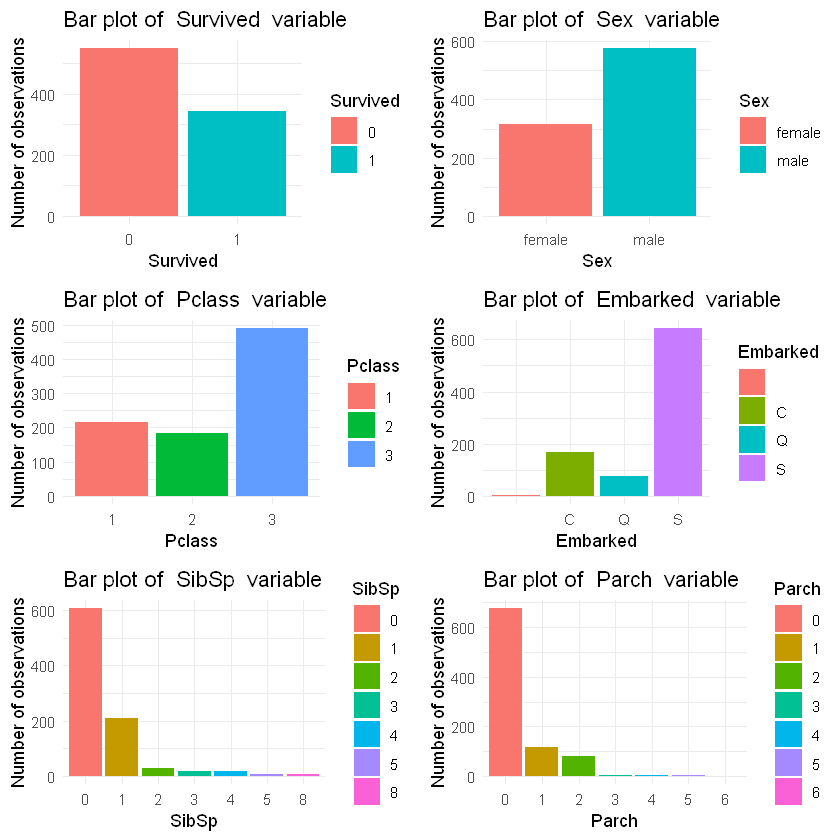

In [50]:
ggpubr::ggarrange(CreateFrequencyDistributionPlot(TrainSet, "Survived"),
                  CreateFrequencyDistributionPlot(TrainSet, "Sex"),
                  CreateFrequencyDistributionPlot(TrainSet, "Pclass"),
                  CreateFrequencyDistributionPlot(TrainSet, "Embarked"),
                  CreateFrequencyDistributionPlot(TrainSet, "SibSp"),
                  CreateFrequencyDistributionPlot(TrainSet, "Parch"),
                  ncol = 2,
                  nrow = 3)

As we can see from the plots most of the people:
- Died;
- Were men;
- Bought tickets for the 3rd class cabins;
- Embarked in Southampton;
- Were alone.

Next we take a look at **Age** variable:

Min,Q25,Median,Q75,Max,Mean,Standard Deviation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.42,20.125,28,38,80,29.69912,14.5265


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 177 rows containing non-finite values (stat_bin)."


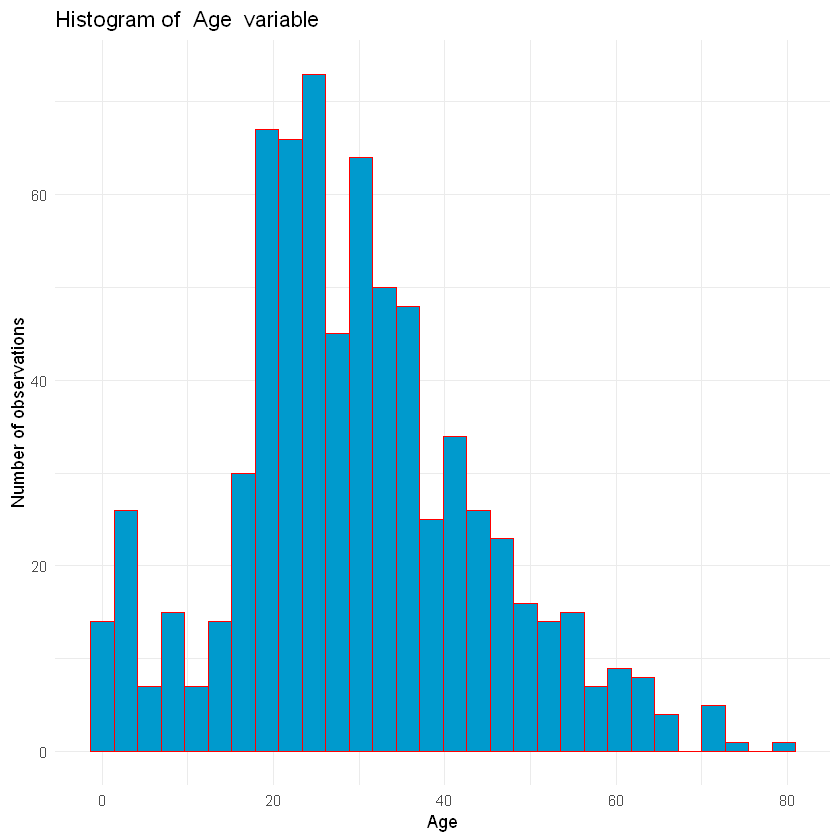

In [51]:
CreateSummaryStatisticsTable(TrainSet$Age)
CreateFrequencyDistributionPlot(TrainSet, "Age", "continuous")

The Age is concentrated around the mean of 28-29 years and reminds a normal distribution with a little skewness to the right.

Next we will inspect **Fare** variable:

Min,Q25,Median,Q75,Max,Mean,Standard Deviation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,7.9104,14.4542,31,512.3292,32.20421,49.69343


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



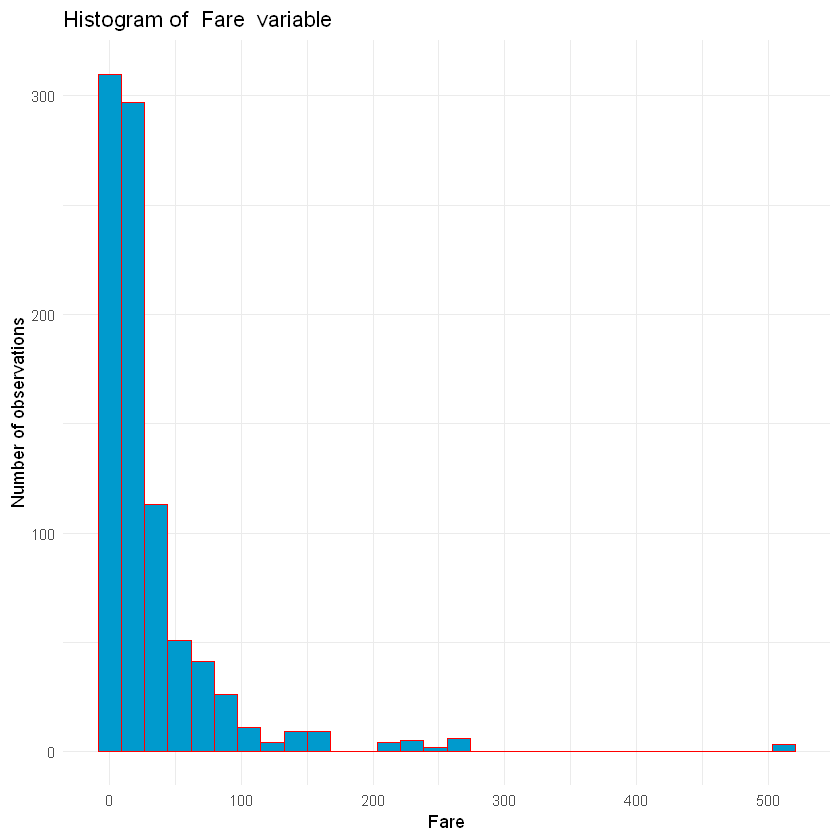

In [52]:
CreateSummaryStatisticsTable(TrainSet$Fare)
CreateFrequencyDistributionPlot(TrainSet, "Fare", "continuous")

The distribution plot is heavily right-skewed which is connected with the **Pclass** variable, as the most of the people bought 3rd class tickets. Log transform of **Fare** can be applied at Feature engeneering part.

---

### Correlations and interdependencies

The first thing here that need to be studied is how wealth affects the probability of surviving. First of all, there's an obvious connection between **Plcass** and **Fare** which is proved by ANOVA test:

In [53]:
TrainSet[, mean(Fare), by = Pclass]
summary(aov(Fare ~ Pclass, data = TrainSet))

Pclass,V1
<fct>,<dbl>
3,13.67555
1,84.15469
2,20.66218


             Df  Sum Sq Mean Sq F value Pr(>F)    
Pclass        2  776030  388015   242.3 <2e-16 ***
Residuals   888 1421769    1601                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

So we could use **Pclass** variable only to see the difference in probability of survival:

In [54]:
TrainSet[, mean(as.numeric(Survived)), by = Pclass]

Pclass,V1
<fct>,<dbl>
3,1.242363
1,1.629630
2,1.472826


As we see, only 24% of survived were from the 3rd class.

Next we have to examine how the departure port influenced the probability of survival:

In [56]:
TrainSet[, mean(as.numeric(Survived)-1), by = Embarked]

Embarked,V1
<fct>,<dbl>
S,0.3369565
C,0.5535714
Q,0.3896104
,1.0000000


The highest survival rate came from  Cherbourg. To understand why we can explore the dependency between average price of ticket and place of departure:

In [58]:
TrainSet[, mean(Fare), by = Embarked]

Embarked,V1
<fct>,<dbl>
S,27.07981
C,59.95414
Q,13.27603
,80.00000


As we can see, the most costly tickets were from Cherbourg.

The next thing we'd like to explore is the influence of Age.

In [59]:
TrainSet[, mean(Age, na.rm = TRUE), by = Survived]

Survived,V1
<fct>,<dbl>
0,30.62618
1,28.34369


However, it happened to be that age did not influenced the probability of survival a lot.

There's also an interesting influence of whether you were on Titanic alone:

In [63]:
TrainSet[, mean(as.numeric(Survived)-1), by = SibSp]
TrainSet[, mean(as.numeric(Survived)-1), by = Parch]

SibSp,V1
<fct>,<dbl>
1,0.5358852
0,0.3453947
3,0.2500000
4,0.1666667
2,0.4642857
5,0.0000000
8,0.0000000


Parch,V1
<fct>,<dbl>
0,0.3436578
1,0.5508475
2,0.5000000
5,0.2000000
3,0.6000000
4,0.0000000
6,0.0000000


Those persons being with max 1-2 spouces were more willing to survive. Morover, the probability of survival for children with 2 parents or adults with 2 children were aslo much higher (did not taking into account sex).

And the last variable to examine is sex:

In [62]:
TrainSet[, mean(as.numeric(Survived)-1), by = Sex]

Sex,V1
<fct>,<dbl>
male,0.1889081
female,0.7420382


Most of the survived persons were women, as there were no boats for men (gentlemen to be correct, as women came out first).

To sum up, to survive you'd better be a rich young woman with a spouse.

## Feature engeneering

---

## Modelling

---

## Model validation

---

## Model improvement

---